In [ ]:
import pandas as pd

# read data
reviews_df = pd.read_csv("/content/drive/MyDrive/App Reviews - App Reviews.csv")
# create the label
reviews_df["is_bad_review"] = reviews_df["score"].apply(lambda x: 1 if x < 3 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

review  is_bad_review
0                                       Janam Usmani              1
1                                               Nice              1
2  Not syncing. The mobile app has all my emails ...              1
3                               It's a very good app              1
4  I should have listened to my gut instinct and ...              1

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))


In [ ]:
reviews_df.head()

review  is_bad_review  \
0                                       Janam Usmani              1   
1                                               Nice              1   
2  Not syncing. The mobile app has all my emails ...              1   
3                               It's a very good app              1   
4  I should have listened to my gut instinct and ...              1   

                                        review_clean  
0                                       janam usmani  
1                                               nice  
2  sync mobile app email i've already read delete...  
3                                           good app  
4  listen gut instinct others review hold allow u...

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In [ ]:
reviews_df.head()

review  is_bad_review  \
0                                       Janam Usmani              1   
1                                               Nice              1   
2  Not syncing. The mobile app has all my emails ...              1   
3                               It's a very good app              1   
4  I should have listened to my gut instinct and ...              1   

                                        review_clean    neg    neu    pos  \
0                                       janam usmani  0.000  1.000  0.000   
1                                               nice  0.000  0.000  1.000   
2  sync mobile app email i've already read delete...  0.000  0.898  0.102   
3                                           good app  0.000  0.484  0.516   
4  listen gut instinct others review hold allow u...  0.066  0.934  0.000   

   compound  
0    0.0000  
1    0.4215  
2    0.3612  
3    0.4927  
4   -0.4404

In [ ]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [ ]:
reviews_df.head()

review  is_bad_review  \
0                                       Janam Usmani              1   
1                                               Nice              1   
2  Not syncing. The mobile app has all my emails ...              1   
3                               It's a very good app              1   
4  I should have listened to my gut instinct and ...              1   

                                        review_clean    neg    neu    pos  \
0                                       janam usmani  0.000  1.000  0.000   
1                                               nice  0.000  0.000  1.000   
2  sync mobile app email i've already read delete...  0.000  0.898  0.102   
3                                           good app  0.000  0.484  0.516   
4  listen gut instinct others review hold allow u...  0.066  0.934  0.000   

   compound  nb_chars  nb_words  
0    0.0000        12         2  
1    0.4215         4         1  
2    0.3612       118        24  
3    0.4927        20         5  
4   -0.4404       268        47

In [ ]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [ ]:
reviews_df.head()

review  is_bad_review  \
0                                       Janam Usmani              1   
1                                               Nice              1   
2  Not syncing. The mobile app has all my emails ...              1   
3                               It's a very good app              1   
4  I should have listened to my gut instinct and ...              1   

                                        review_clean    neg    neu    pos  \
0                                       janam usmani  0.000  1.000  0.000   
1                                               nice  0.000  0.000  1.000   
2  sync mobile app email i've already read delete...  0.000  0.898  0.102   
3                                           good app  0.000  0.484  0.516   
4  listen gut instinct others review hold allow u...  0.066  0.934  0.000   

   compound  nb_chars  nb_words  doc2vec_vector_0  doc2vec_vector_1  \
0    0.0000        12         2          0.011788          0.083502   
1    0.4215         4         1          0.017214          0.070360   
2    0.3612       118        24          0.098004          0.088483   
3    0.4927        20         5          0.003188          0.096888   
4   -0.4404       268        47          0.000112         -0.044587   

   doc2vec_vector_2  doc2vec_vector_3  doc2vec_vector_4  
0         -0.065447         -0.024277         -0.080573  
1         -0.038548         -0.013527          0.013946  
2         -0.081580          0.003206         -0.068780  
3          0.063865         -0.035902          0.067126  
4          0.014699         -0.070220          0.049925

In [ ]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
reviews_df.head()

review  is_bad_review  \
0                                       Janam Usmani              1   
1                                               Nice              1   
2  Not syncing. The mobile app has all my emails ...              1   
3                               It's a very good app              1   
4  I should have listened to my gut instinct and ...              1   

                                        review_clean    neg    neu    pos  \
0                                       janam usmani  0.000  1.000  0.000   
1                                               nice  0.000  0.000  1.000   
2  sync mobile app email i've already read delete...  0.000  0.898  0.102   
3                                           good app  0.000  0.484  0.516   
4  listen gut instinct others review hold allow u...  0.066  0.934  0.000   

   compound  nb_chars  nb_words  doc2vec_vector_0  ...  word_user   word_ve  \
0    0.0000        12         2          0.011788  ...        0.0  0.000000   
1    0.4215         4         1          0.017214  ...        0.0  0.000000   
2    0.3612       118        24          0.098004  ...        0.0  0.337883   
3    0.4927        20         5          0.003188  ...        0.0  0.000000   
4   -0.4404       268        47          0.000112  ...        0.0  0.000000   

   word_version  word_video  word_want  word_way  word_well  word_work  \
0           0.0         0.0        0.0       0.0        0.0        0.0   
1           0.0         0.0        0.0       0.0        0.0        0.0   
2           0.0         0.0        0.0       0.0        0.0        0.0   
3           0.0         0.0        0.0       0.0        0.0        0.0   
4           0.0         0.0        0.0       0.0        0.0        0.0   

   word_would  word_year  
0         0.0        0.0  
1         0.0        0.0  
2         0.0        0.0  
3         0.0        0.0  
4         0.0        0.0  

[5 rows x 136 columns]

In [ ]:
reviews_df.to_csv("Cleaned_training_data.csv")

Exploratory data analysis

In [ ]:
import pandas as pd
reviews_df = pd.read_csv("/content/Cleaned_training_data.csv")

In [ ]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.60241
1    0.39759
Name: is_bad_review, dtype: float64

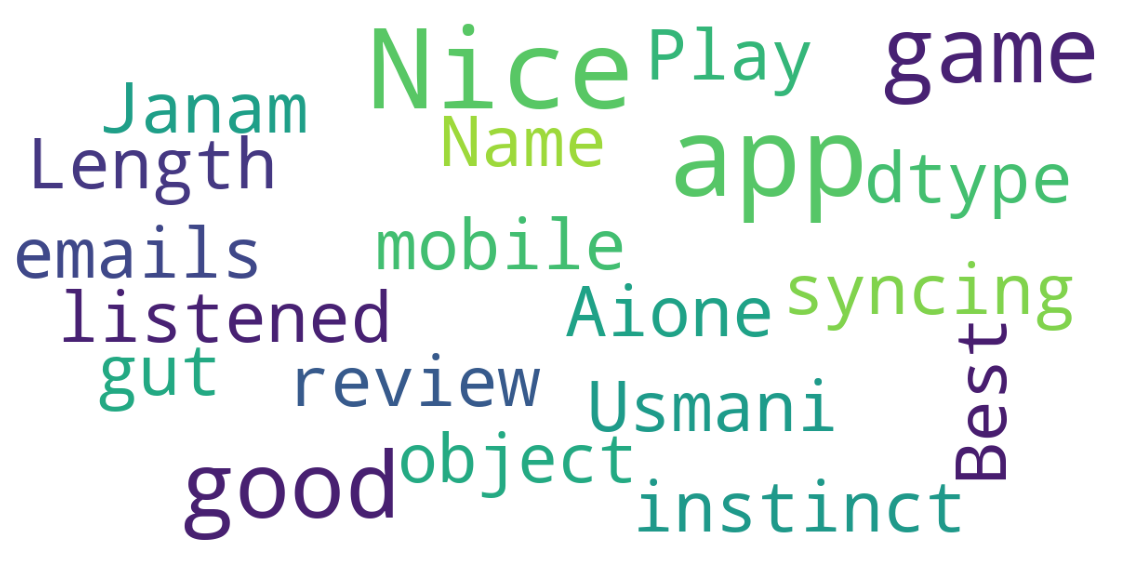

In [ ]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [ ]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

review    pos
786                                 Nice app i love it  0.778
442                 I love it like my favorite podcast  0.764
546                       Loved it it's really amazing  0.727
529                    Awesome , This app most helpful  0.706
938  Best 6 I love my id ludo king I am best playin...  0.673
351                             Very good app and easy  0.670
165                      Good prodect and good quality  0.659
347       Excellent service and friendly behavior ride  0.633
882  Sounds good n hopeful. And fun to play. Lets h...  0.622
288         It's a good app...not user friendly though  0.604

In [ ]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)


review    neg
105                      Evil app owned by evil people  0.688
457                           Worst app West your time  0.506
846                               This app is very bad  0.487
799  One of the stupid app am ever seen.. worst dev...  0.484
746  No 1 worst application tooooomuch add Not inst...  0.474
50                                Bad app not find job  0.467
553  Dead app. No update in two years. Try competit...  0.448
6    When I mark spam as "looks safe", stop sending...  0.444
365                Poor experience with this appp😏😏😏😏😏  0.437
259  i put 1 star cause it's a stupid discord 🙄🙄 i ...  0.436

In [ ]:
# plot sentiment distribution for positive and negative reviews
import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Modelling is_bad_review

In [ ]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [ ]:
# print(X_train)
print(len(X_train), len( X_test), len(X_val), len(y_train), len(y_test), len(y_val))

597 200 199 597 200 199


In [ ]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head()

feature  importance
0        Unnamed: 0    0.083403
3               pos    0.075519
7  doc2vec_vector_0    0.071200
8  doc2vec_vector_1    0.060701
4          compound    0.060564

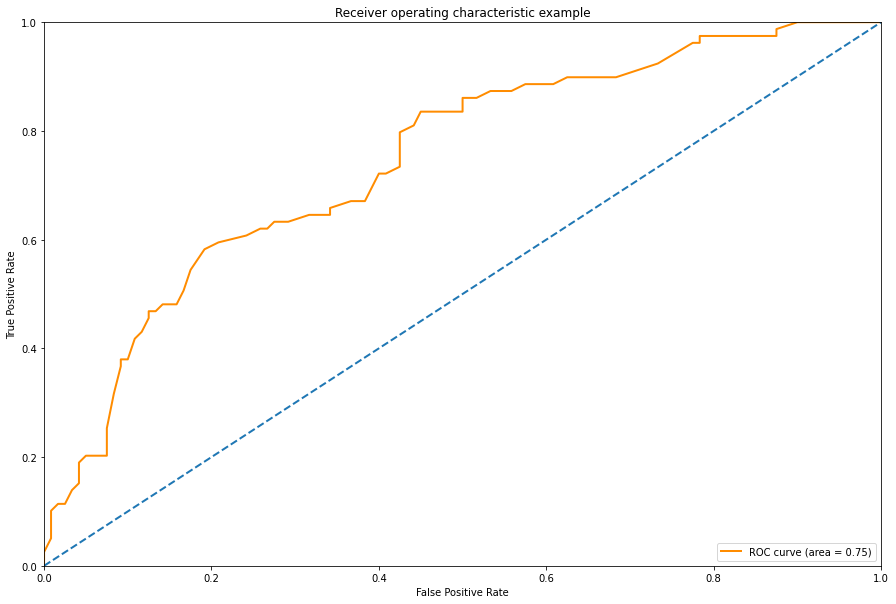

In [ ]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_val)]
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
pip install funcsigs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve, accuracy_score
# from sklearn.utils.fixes import signature
from funcsigs import signature

average_precision = average_precision_score(y_val, y_pred)
#accuracy = accuracy_score(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_pred)

#print("Accuracy = ", accuracy)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.65')

In [ ]:
def rev_type(val):
    return "Good review" if val == 0 else "Bad review"

In [ ]:
import numpy as np

In [ ]:
prediction = [x[1] for x in rf.predict_proba(X_test)]
for pred in prediction:
    value = np.argmax(pred)
    rev = rev_type(value)
    print("Prediction is {}.".format(rev))

Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
Prediction is Good review.
P